# Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output
import sklearn
import os
import time

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')



# Подготовка данных

## Инициализация параметров

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

selected_model = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(selected_model)

BATCH_SIZE = 32
EPOCHS = 20
EARLY_STOP = 3
OPT = torch.optim.NAdam
LEARNING_RATE = 3e-5
EPSILON = 1e-8
SCHEDULER = False
SAMPLE = False


## Создание датасета

In [17]:
def make_dataset(texts, labels):
    '''
    Токенизация текстов и сопоставление токенов с идентификаторами
    соответствующих им слов. Формирование PyTorch датасета
    '''
    input_ids = []        # Список для токенизированных текстов
    attention_masks = []  # Список для масок механизма внимания
    
    # Цикл проходится и токенизирует каждый текст
    for seq_to_token in texts:
        encoded_dict = tokenizer.encode_plus(
            seq_to_token,                # Последовательность для токенизации
            add_special_tokens=True,     # Добавить специальные токены в начало и в конец посл-ти
            max_length=338,              # Максимальная длина последовательности
            padding='max_length',        # Токен для заполнения до максимальной длины
            return_attention_mask=True,  # Маска механизма внимания для указания на паддинги
            return_tensors = 'pt',       # Возвращать pytorch-тензоры
            truncation=True              # Обрезать последовательность до максимальной длины
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Конкатенация входных данных в тензоры
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # Преобразование таргетов в тензоры
    labels = torch.tensor(labels.values)
    # Формирование датасета
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

## Алгоритмы обучения и проверки

In [16]:
def train(epoch):
    '''
    Обучение модели на одной эпохе
    '''
    print(f'Epoch {epoch+1}')
    model.train()           
    fin_targets = []        # Список для всех таргетов обучающей выборки
    fin_outputs = []        # Список для всех предиктов модели на обучающей выборки
    total_train_loss = 0    # Функция потерь на обучении
    
    # Цикл проходится по батчам из обучающей выборки
    for data in train_dataloader:
        ids = data[0].to(device, dtype=torch.long)              # Токены последовательностей из батча
        mask = data[1].to(device, dtype=torch.long)             # Маски механизма внимания последовательностей
        targets = data[2].to(device, dtype=torch.float)         # Таргеты из батча
        
        res = model(ids, attention_mask=mask, labels=targets)   # В модель подаются входные тензоры и таргеты
        loss = res['loss']                                      # Вычисляется значение функции потерь
        logits = res['logits']                                  # Логиты предсказаний модели
        total_train_loss += loss.item()                         # Считается функция потерь
        
        # Таргеты и выходы модели по батчу добавляются в списки. Логиты проходят через сигмоиду
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist())
        
        optimizer.zero_grad()                                   # Зануляются градиенты параметров модели
        loss.backward()                                         # По функции потерь рассчитываются градиенты
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Масштабируются градиенты
        optimizer.step()                                        

    
    fin_targets = np.array(fin_targets)
    fin_outputs = np.array(fin_outputs)
    predictions = np.zeros(fin_outputs.shape)
    predictions[np.where(fin_outputs >= 0.5)] = 1
    
    return total_train_loss / len(train_dataloader), fin_targets, predictions


def validate():
    '''
    Валидация обученной модели на тестовой выборке
    '''
    print(f'Validation')
    model.eval()             
    fin_targets = []         # Список для всех таргетов валидационной выборки
    fin_outputs = []         # Список для всех предиктов модели на валидационной выборки
    total_test_loss = 0.0    # Функция потерь на валидации
    
    with torch.no_grad():
        # Без подсчета градиентов цикл проходится по батчам
        for data in test_dataloader:
            ids = data[0].to(device, dtype=torch.long)            # Токены последовательностей из батча
            mask = data[1].to(device, dtype=torch.long)           # Маски механизма внимания последовательностей
            targets = data[2].to(device, dtype=torch.float)       # Таргеты из батча
                
            res = model(ids, attention_mask=mask, labels=targets) # В модель подаются входные тензоры и таргеты
            loss = res['loss']                                    # Вычисляется значение функции потерь
            logits = res['logits']                                # Логиты предсказаний модели
            total_test_loss += loss.item()                        # Считается функция потерь
            
            # Таргеты и выходы модели по батчу добавляются в списки. Логиты проходят через сигмоиду
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist())
    
    fin_targets = np.array(fin_targets)
    fin_outputs = np.array(fin_outputs)
    predictions = np.zeros(fin_outputs.shape)
    predictions[np.where(fin_outputs >= 0.5)] = 1
    
    return total_test_loss / len(test_dataloader), fin_targets, predictions

## Метрики

In [9]:
def identity(y_test, y_pred):
    '''
    Расчёт похожести объектов через расстояние Хэмминга

    y_test - тестовые целевые данные

    y_pred - предсказанные целевые данные

    Вывод среднего значения похожести объектов по всем элементам 

    '''
    try:
        y_true = y_test.to_numpy()
    except:
        y_true = y_test

    if (len(y_true) != len(y_pred)):

        raise Exception('Объекты должны быть одинаковой длины')
    identity_list = []
    for elem in range(len(y_true)):
        #print('true:', y_true[elem])
        #print('pred:', y_pred[elem])
        #print(len(y_true[elem]) == len(y_pred[elem]))
        #print(len(y_test[elem]))
        if (len(y_true[elem]) != len(y_pred[elem])):

            raise Exception('Элементы должны быть одинаковой длины')
        # Инициализация переменной расстояния Хэмминга
        dist_counter = 0
        for n in range(len(y_true[elem])):
            # Изменение расстояния Хэмминга при наличии разницы между объектами
            if y_true[elem][n] != y_pred[elem][n]:
                
                dist_counter += 1
                
        len_elem = len(y_true[elem])
        # Расчёт доли похожести элементов двух объектов через Расстояние Хэмминга(dist_counter/len_elem - доля непохожести двух объектов)
        identity = round(1 - dist_counter/len_elem, 3)
        identity_list.append(identity)

    return round(np.mean(identity_list),5)

In [10]:
def hamming_distance(y_test, y_pred):
    '''
    Расчёт доработанного расстояния Хэмминга с ориентацией на целевое значение = 1

    y_test - тестовые целевые данные

    y_pred - предсказанные целевые данные

    Вывод среднего значения расстояния Хэмминга по всем элементам 

    '''
    try:
        y_true = y_test.to_numpy()
    except:
        y_true = y_test

    if (len(y_true) != len(y_pred)):
        raise Exception('Объекты должны быть одинаковой длины')
    distance_list = []
    
    for elem in range(len(y_true)):
        if (len(y_true[elem]) != len(y_pred[elem])):
            raise Exception('Элементы должны быть одинаковой длины')

        indices_1_y_true = set(np.where(y_true[elem])[0])
        indices_1_y_pred = set(np.where(y_pred[elem])[0])
        
        if len(indices_1_y_true) == 0 and len(indices_1_y_pred) == 0:
            dist_counter = 1

        else:
            dist_counter = len(indices_1_y_true.intersection(indices_1_y_pred)) / float(len(indices_1_y_true.union(indices_1_y_pred)))

        distance_list.append(dist_counter)
    return round(np.mean(distance_list),5)

In [11]:
def estimation(y_test, y_pred, columns, save_file=False, filename='filename'):
    '''
    Вывод результирующих метрик
    '''
    try:
        y_true = y_test.to_numpy()
    except:
        y_true = y_test
    print('Accuracy:', round(accuracy_score(y_true, y_pred), 5))
    print('Hamming distance:', hamming_distance(y_test, y_pred))
    print('Identity (by Hamming distance):', identity(y_test, y_pred), '\n')
    print(classification_report(y_true, y_pred, target_names=columns, zero_division=0))
    
    if save_file is True:
        np.savetxt(filename, y_pred.astype(int), fmt='%i', delimiter=',')

In [12]:
def cm_show(y_test, y_pred, nrows=10, ncols=5, figsize_w=30, figsize_h=60, wspace=0.2, hspace=0.4):
    '''
    Вывод матрицы несоответствия для каждой тематической категории в формате:   
    
    [['TN', 'FP'],
     ['FN', 'TP']]

    y_test - тестовые целевые данные

    y_pred - предсказанные целевые данные

    nrows - количество строк в сетке матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: nrows = figsize_h / 6)

    ncols - количество столбцов в сетке матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: ncols = figsize_w / 6)

    figsize_w - ширина полотна для вывода сетки матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: figsize_h = 6 * ncols)

    figsize_h - высота полотна для вывода сетки матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: figsize_h = 6 * nrows)

    wspace - расстояние по ширине между отдельными ячейками сетки матриц несоответствия

    hspace - расстояние по высоте между отдельными ячейками сетки матриц несоответствия
    '''
    
    start = time.time()
    try:
        y_true = y_test.to_numpy()
    except:
        y_true = y_test
    axis = plt.subplots(nrows, ncols, figsize=(figsize_w, figsize_h))[1]
    axis = axis.ravel()
    
    # обычная матрица несоответствий
    # actual = np.array(y_true).T
    # predicted = np.array(y_pred).T
    
    # for tag_num in range(len(y_test.columns)):
    #    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(actual[tag_num], predicted[tag_num]),
    #                                        display_labels = [0,1])
    #    cm_display.plot(ax=axis[tag_num],cmap=plt.cm.GnBu)
    #    cm_display.ax_.set_title(f'{y_test.columns[tag_num]}')
    
    # многоклассовая матрица несоответствий
    mlcm = multilabel_confusion_matrix(y_true, y_pred)
        
    for tag_num in range(len(y_test.columns)):
    #    Если надо отобразить количество
    #    mlcm_display = ConfusionMatrixDisplay(confusion_matrix = mlcm[i], display_labels = [0,1]) 
    #    mlcm_display.plot(ax=axis[tag_num],cmap=plt.cm.GnBu)
    #    mlcm_display.ax_.set_title(f'{y_test.columns[tag_num]}') 

    #   Если надо отобразить проценты. 
    #   Так как в рамках задачи наибольший интерес вызывает информация о точном предсказании (y_true = 1, y_pred = 1)
    #   или о грубой ошибке при предсказании (y_true = 1, y_pred = 0) категории, имеет смысл выводить информацию для
    #   дальнейшего анализа в виде доли верных и неверных предсказаний для целевого значения = 1. 
        mlcm_percent = mlcm[tag_num] / mlcm[tag_num].sum(axis=1).reshape(2, -1)
        
        true0_row = mlcm[tag_num].sum(axis=1)[0] # количество TN, FP предсказаний (нецелевое значение = 0)
        true1_row = mlcm[tag_num].sum(axis=1)[1] # количество TP, FN предсказаний (целевое значение = 1)
        
        mlcm_percent_display = ConfusionMatrixDisplay(mlcm_percent, display_labels=[0, 1])        
        mlcm_percent_display.plot(ax=axis[tag_num],cmap=plt.cm.GnBu, values_format="0.3f")
        mlcm_percent_display.ax_.set_title(f'{y_test.columns[tag_num]} (TL0: {true0_row}, TL1:{true1_row})') 

    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
    return print(f'Время выполнения: {round(time.time() - start,3)} с')

In [13]:
def log_metrics(history, writer, loss, targets, outputs, postfix):
    '''
    Расчет значений метрик и добавление их в лог обучения для отрисовки графиков.
    Добавление значений метрик в историю обучения для отрисовки временных графиков
    '''
    metrics_dict = {
        'Loss': loss,
        'Accuracy': metrics.accuracy_score(targets, outputs),
        'Hamming_distance': hamming_distance(targets, outputs),
        'F1_micro': metrics.f1_score(targets, outputs, average='micro'),
        'F1_macro': metrics.f1_score(targets, outputs, average='macro'),
        'Recall_micro': metrics.recall_score(targets, outputs, average='micro'),
        'Recall_macro': metrics.recall_score(targets, outputs, average='macro'),
        'Precision_micro': metrics.precision_score(targets, outputs, average='micro', zero_division=0.0),
        'Precision_macro': metrics.precision_score(targets, outputs, average='macro', zero_division=0.0)
    }
    
    for metric, value in metrics_dict.items():
        if not 'macro' in metric:
            history[metric][postfix].append(value)
        writer.add_scalar(f'{metric}/{postfix}', value, epoch)


def plot_learning_curves(history):
    '''
    Отрисовка обновляющихся графиков значений метрик,
    для отслеживания в процессе обучения
    '''
    fig = plt.figure(figsize=(20, 10))
    
    for i, metric in enumerate(history.keys(), 1):
        plt.subplot(2,3,i)
        plt.title(metric, fontsize=15)
        plt.plot(range(1, epoch+2), history[metric]['train'], label='train')
        plt.plot(range(1, epoch+2), history[metric]['val'], label='val')
        plt.xticks(range(1, epoch+2))
        if i > 3:
            plt.xlabel('epoch', fontsize=15)
        plt.legend()

    plt.show()

# Подготовка модели

## Загрузка обучающего и тестового датасетов

In [ ]:
df_train = pd.read_csv('..\\Датасеты\\news_train.csv')
df_test = pd.read_csv('..\\Датасеты\\news_test.csv')

# При проведении экспериментов берется четверть от обучающей выборки
if SAMPLE:
    df_train = df_train.sample(frac=0.25, random_state=42)

X_train, y_train = df_train['text_lemma'], df_train.drop('text_lemma', axis=1)
X_test, y_test = df_test['text_lemma'], df_test.drop('text_lemma', axis=1)

## Создание обучающего и тестового датасетов в формате тензоров

In [19]:
train_dataset = make_dataset(X_train, y_train)
test_dataset = make_dataset(X_test, y_test)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Инициализация модели

In [ ]:
# Инициализируется предобученная модель
model = AutoModelForSequenceClassification.from_pretrained(
    selected_model,
    problem_type='multi_label_classification', # Решается задача многоклассовой классификации. Функция потерь BCEWithLogitsLoss
    num_labels=y_test.shape[1],                # Число классов
    output_attentions = False,                 # Модель не выдает результаты работы механизма внимания
    output_hidden_states = False               # Модель не выдает скрытые состояния
)
model.to(device)

# Инициализируется оптимизатор
optimizer = OPT(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=EPSILON
)

# Инициализируется шедулер
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * EPOCHS
)

# Инициализируется инструмент логирования
writer = SummaryWriter(
    comment= '-' + selected_model.replace('/', '-')
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/rubert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Обучение модели

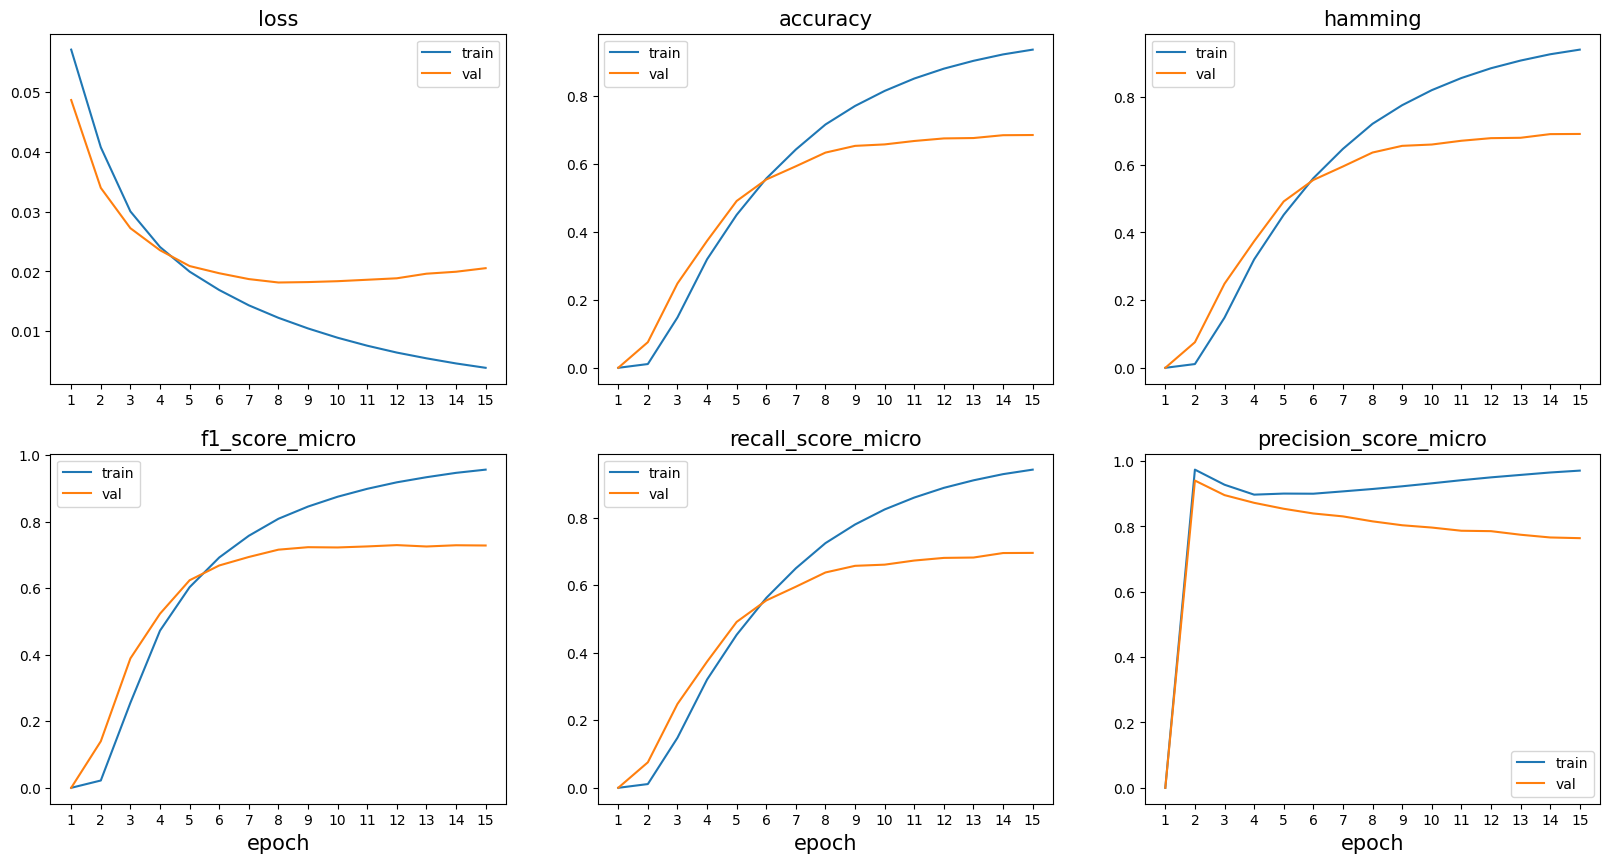

CPU times: user 58min 43s, sys: 15.4 s, total: 58min 58s
Wall time: 59min 18s


In [ ]:
%%time
# Переменная для хранения лучшей метрики для ранней остановки
best_f1_val = 0
# Переменная для отсчета количества эпох с момента лучшей метрики
epochs_since_best = 0
# Словарь для хранения истории метрик
history = defaultdict(lambda: defaultdict(list))

for epoch in range(EPOCHS):

    avg_train_loss, targets, outputs = train(epoch)                         # Обучение модели на одной эпохе
    log_metrics(history, writer, avg_train_loss, targets, outputs, 'train') # Логирование метрик

    avg_val_loss, targets, outputs = validate()                             # Предсказания модели на вал. выборке
    log_metrics(history, writer, avg_val_loss, targets, outputs, 'val')     # Логирование метрик

    clear_output()
    # Отрисовка кривых обучения
    plot_learning_curves(history)
    #torch.save(model, '..\\Результаты\\models\\' + f"{selected_model.replace('/', '-')}_{epoch}.pt")
    # Расчет micro f1-score на валидационной выборке
    f1_val = metrics.f1_score(targets, outputs, average='micro')
    # Если метрика лучше предыдущей лучшей, то сохраняется модель
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        torch.save(model, '..\\Результаты\\models\\' + f"{selected_model.replace('/', '-')}.pt")
        epochs_since_best = 0
    # В противном случае идет отсчет эпох до ранней остановки
    else:
        epochs_since_best += 1
    print('Best epoch:', epoch, '\nBest F1-score:',best_f1_val, '\n')
    if epochs_since_best == EARLY_STOP:
        break

writer.flush()
writer.close()

# Результаты

## Результаты обученной модели

### Загрузка моделей, выбор лучшей, предсказание и оценка

In [ ]:
model_list = []
for i in os.listdir('..\\Результаты\\models\\'):
  if i.find('cointegrated-rubert-tiny2') != -1:
    model_list.append(i)
  else:
    pass
model_list

['cointegrated-rubert-tiny2_0.pt',
 'cointegrated-rubert-tiny2_1.pt',
 'cointegrated-rubert-tiny2_10.pt',
 'cointegrated-rubert-tiny2_11.pt',
 'cointegrated-rubert-tiny2_12.pt',
 'cointegrated-rubert-tiny2_13.pt',
 'cointegrated-rubert-tiny2_14.pt',
 'cointegrated-rubert-tiny2_3.pt',
 'cointegrated-rubert-tiny2_4.pt',
 'cointegrated-rubert-tiny2_5.pt',
 'cointegrated-rubert-tiny2_6.pt',
 'cointegrated-rubert-tiny2_7.pt',
 'cointegrated-rubert-tiny2_8.pt',
 'cointegrated-rubert-tiny2_9.pt']

In [ ]:
for model_result in model_list:
    try:
        model = torch.load('..\\Результаты\\models\\' + model_result, weights_only=False)
        avg_val_loss, targets, outputs = validate()
        estimation(targets, outputs, y_test.columns, save_file=False, filename='..\\Результаты\\models_csv\\' + f"{model_result[:-3]}.csv")
    except:
        pass

### Загрузка модели, предсказание и оценка

In [ ]:
n = int(input('input model number'))
model = torch.load('..\\Результаты\\models\\' + f"{selected_model.replace('/', '-')}_{n}.pt", weights_only = False)
avg_val_loss, targets, outputs = validate()
estimation(targets, outputs, y_test.columns, save_file=True, filename= '..\\Результаты\\models_csv\\' + f"{selected_model.replace('/', '-')}_{n}.csv")

Validation
Accuracy: 0.68557
Hamming distance: 0.69075
Identity (by Hamming distance): 0.99429 

                      precision    recall  f1-score   support

             Coцсети       0.82      0.74      0.78       200
                Авто       0.96      0.96      0.96        28
          Автобизнес       0.68      0.73      0.70        62
          Белоруссия       0.89      0.86      0.88       183
              Бизнес       0.72      0.53      0.61       200
          Бокс и ММА       0.98      0.95      0.97       200
         Бывший СССР       0.77      0.82      0.79       200
                Вещи       0.50      0.15      0.23        85
     Вирусные ролики       0.76      0.72      0.74        95
               Вкусы       0.00      0.00      0.00        11
         Внешний вид       0.81      0.90      0.85       145
             Гаджеты       0.74      0.73      0.74       200
               Город       0.54      0.53      0.53       200
        Госэкономика       0.73   

### Матрицы несоответствий по категориям

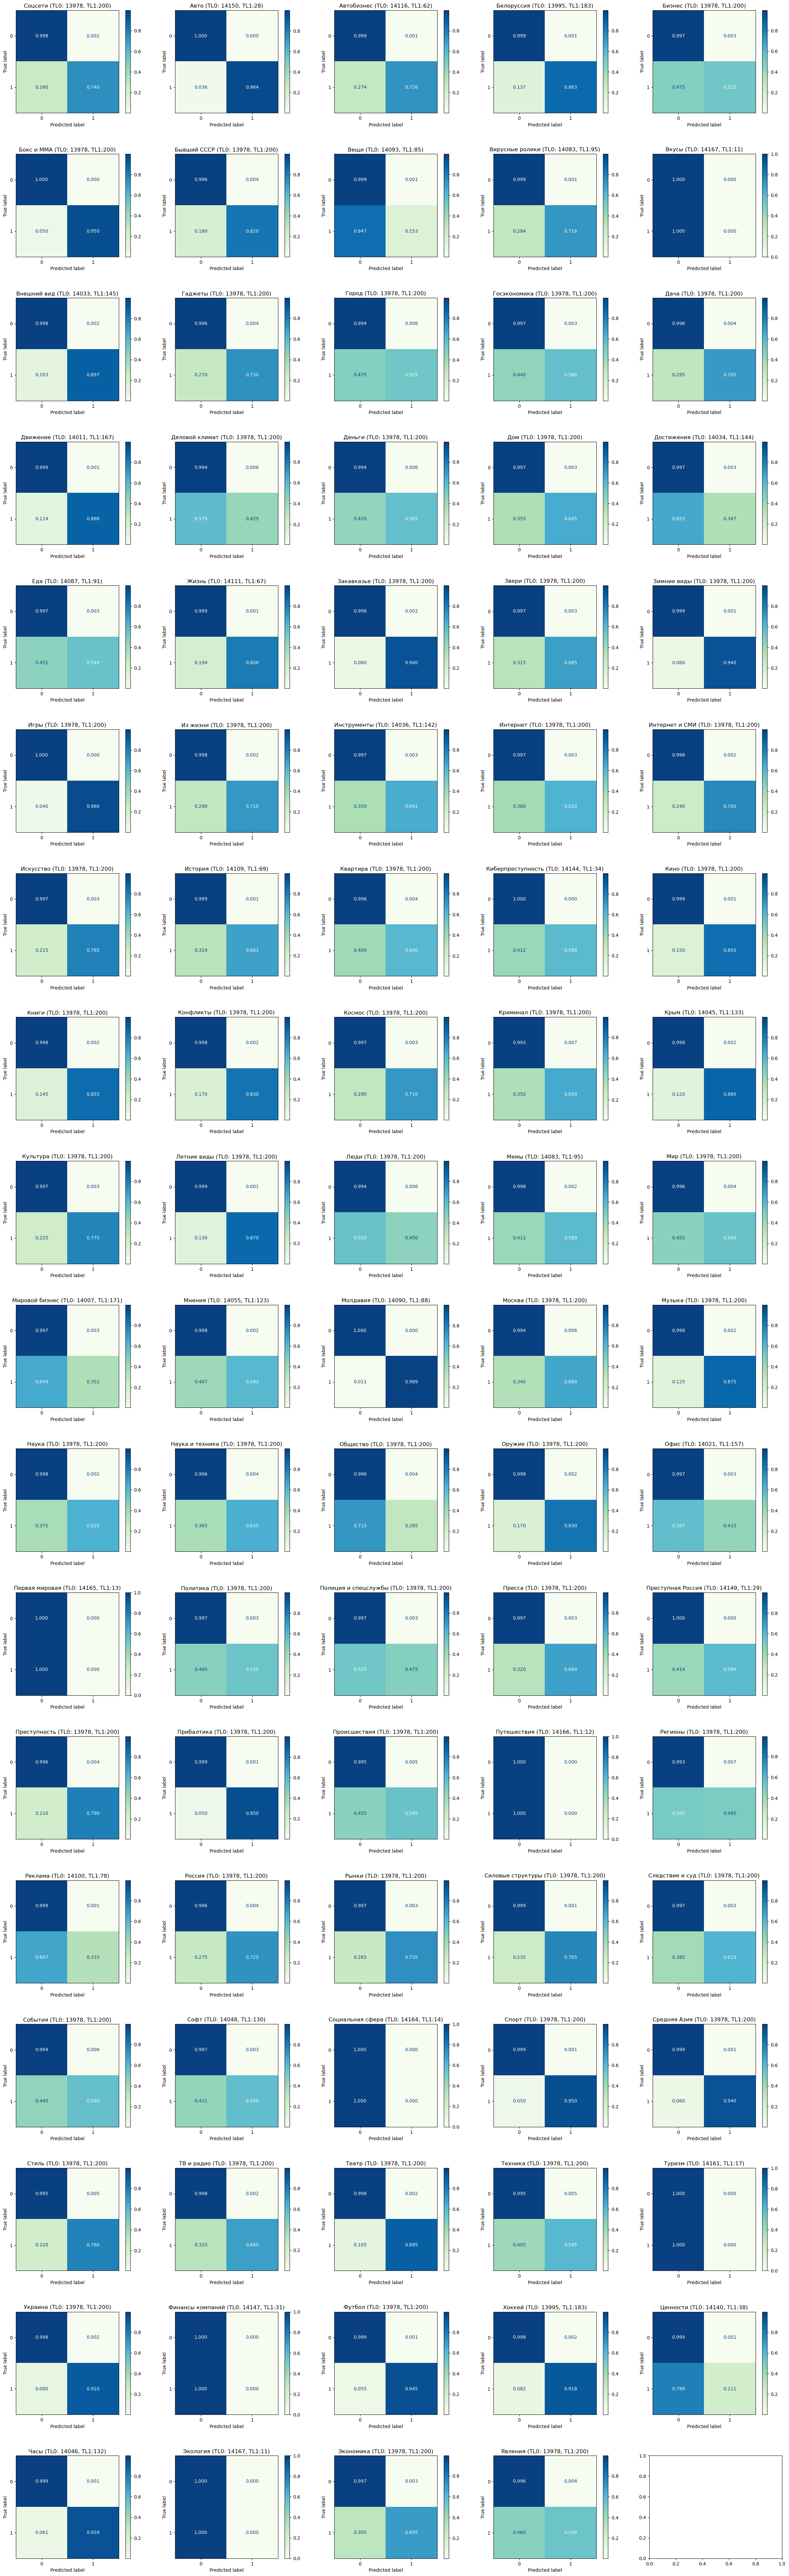

Время выполнения: 6.989 с


In [27]:
cm_show(y_test, 
        outputs, 
        nrows=18, 
        ncols=5, 
        figsize_w=30, 
        figsize_h=100, 
        wspace=0.2, 
        hspace=0.4
        )